# Домашнее задание: Обучение и визуализация трансформера

Цель задания

Обучить простую модель трансформера для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
Визуализировать веса внимания и интерпретировать их
Сделать выводы о том, как модель воспринимает данные и принимает решения

In [20]:
import math
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [21]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [22]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Разбиваем на списки строк
train_texts = dataset["train"]["text"]
valid_texts = dataset["validation"]["text"]
test_texts = dataset["test"]["text"]

tokenizer = get_tokenizer("basic_english")


# Функция-генератор токенов для построения словаря
def yield_tokens_from_list(text_list):
    for line in text_list:
        if line is None or line.strip() == "":
            continue
        yield tokenizer(line)


# Строим словарь по тренировочному набору
vocab = build_vocab_from_iterator(
    yield_tokens_from_list(train_texts),
    specials=["<pad>", "<unk>"]
)
vocab.set_default_index(vocab["<unk>"])  # индекс для OOV-слов

In [23]:
# Функция для превращения списка строк в пары (sequence, target)
def data_process(text_list, max_len=128, stride=128):
    all_ids = []
    for line in text_list:
        if line is None or line.strip() == "":
            continue
        tokens = tokenizer(line)
        all_ids.extend([vocab[token] for token in tokens])
    if len(all_ids) < max_len + 1:
        return []
    ids = torch.tensor(all_ids, dtype=torch.long)

    num_subseq = (len(ids) - 1) // stride
    sequences = [ids[i * stride: i * stride + max_len] for i in range(num_subseq)]
    targets = [ids[i * stride + 1: i * stride + max_len + 1] for i in range(num_subseq)]
    return list(zip(sequences, targets))

In [24]:
# Преобразуем train/valid/test в списки пар (sequence, target)
train_data_full = data_process(train_texts)
val_data_full = data_process(valid_texts)
test_data_full = data_process(test_texts)

# Чтобы обучение уложилось в разумные сроки, возьмём больше блоков, но не все:
train_data = train_data_full[:15000]
val_data = val_data_full[:3000]
test_data = test_data_full[:3000]
print(f"Train sequences: {len(train_data)},  Val sequences: {len(val_data)},  Test sequences: {len(test_data)}")

# Индекс для паддинга
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 64

Train sequences: 15000,  Val sequences: 1677,  Test sequences: 1891


In [25]:
class LMDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]


def collate(batch):
    src, tgt = zip(*batch)
    src = nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=PAD_IDX)
    tgt = nn.utils.rnn.pad_sequence(tgt, batch_first=True, padding_value=PAD_IDX)
    return src.to(device), tgt.to(device)


train_loader = DataLoader(
    LMDataset(train_data),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate,
    drop_last=True
)
val_loader = DataLoader(
    LMDataset(val_data),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate,
    drop_last=True
)

In [26]:
class GPTMini(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2,
                 dim_feedforward=256, max_len=128):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.norm = nn.LayerNorm(d_model)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, x, need_attn=False):
        B, L = x.shape
        pos = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, L)
        h = self.tok_emb(x) + self.pos_emb(pos)

        # causal (triangular) mask: запрещаем смотреть вперед
        causal_mask = torch.ones(L, L, device=x.device).triu(1).bool()

        if need_attn:
            attns = []

            # Регистрируем хук на MultiheadAttention внутри каждого слоя
            def hook(m, inp, outp):
                # outp: tuple (attn_output, attn_output_weights)
                attn_weights = outp[1]  # [B, num_heads, L, L]
                attns.append(attn_weights.detach())

            handles = [
                blk.self_attn.register_forward_hook(hook)
                for blk in self.transformer.layers
            ]

        h = self.transformer(h, mask=causal_mask)

        if need_attn:
            for hdl in handles:
                hdl.remove()
            final_attn = attns[-1]  # веса внимания последнего слоя

        h = self.norm(h)
        logits = self.out(h)
        return (logits, final_attn) if need_attn else (logits, None)


vocab_size = len(vocab)
model = GPTMini(vocab_size).to(device)
num_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Model parameters: {num_params:.2f} M")

Model parameters: 17.26 M


In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

# Настроим CosineAnnealingLR так, чтобы 5 эпох != полное T_max
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=5 * len(train_loader) * 3  # чтобы lr не слишком быстро уходило в 0
)


def train_epoch(loader):
    model.train()
    total_loss, toks = 0.0, 0

    batch_iter = tqdm(loader, desc="  Training", leave=False)
    for xb, yb in batch_iter:
        optimizer.zero_grad()
        logits, _ = model(xb)  # [B, L, vocab_size]
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        non_pad = (yb != PAD_IDX).sum().item()
        total_loss += loss.item() * non_pad
        toks += non_pad

        avg_ppl = math.exp(total_loss / toks) if toks > 0 else float('inf')
        batch_iter.set_postfix(train_ppl=avg_ppl)

    avg_loss = total_loss / toks if toks > 0 else float('inf')
    return avg_loss

In [28]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, toks = 0.0, 0

    batch_iter = tqdm(loader, desc="  Validation", leave=False)
    for xb, yb in batch_iter:
        logits, _ = model(xb)
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        non_pad = (yb != PAD_IDX).sum().item()
        total_loss += loss.item() * non_pad
        toks += non_pad

        avg_ppl = math.exp(total_loss / toks) if toks > 0 else float('inf')
        batch_iter.set_postfix(val_ppl=avg_ppl)

    avg_loss = total_loss / toks if toks > 0 else float('inf')
    return avg_loss

In [29]:
EPOCHS = 5
train_loss_list = []
val_loss_list = []
lr_list = []

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    t0 = time.time()

    avg_train_loss = train_epoch(train_loader)
    train_loss_list.append(avg_train_loss)

    avg_val_loss = evaluate(val_loader)
    val_loss_list.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    lr_list.append(current_lr)

    train_ppl_epoch = math.exp(avg_train_loss) if avg_train_loss < float('inf') else float('inf')
    val_ppl_epoch = math.exp(avg_val_loss) if avg_val_loss < float('inf') else float('inf')
    elapsed = time.time() - t0
    print(f"  train ppl={train_ppl_epoch:.2f}  val ppl={val_ppl_epoch:.2f}  "
          f"loss=[{avg_train_loss:.4f}/{avg_val_loss:.4f}]  lr={current_lr:.6f}  [{elapsed:.1f}s]\n")

Epoch 1/5


  Training:   0%|          | 0/234 [00:00<?, ?it/s]

  Validation:   0%|          | 0/26 [00:00<?, ?it/s]

  train ppl=2720.97  val ppl=1190.38  loss=[7.9087/7.0820]  lr=0.000297  [369.6s]

Epoch 2/5


  Training:   0%|          | 0/234 [00:00<?, ?it/s]

  Validation:   0%|          | 0/26 [00:00<?, ?it/s]

  train ppl=956.85  val ppl=967.59  loss=[6.8636/6.8748]  lr=0.000287  [397.6s]

Epoch 3/5


  Training:   0%|          | 0/234 [00:00<?, ?it/s]

  Validation:   0%|          | 0/26 [00:00<?, ?it/s]

  train ppl=782.53  val ppl=850.48  loss=[6.6625/6.7458]  lr=0.000271  [353.3s]

Epoch 4/5


  Training:   0%|          | 0/234 [00:00<?, ?it/s]

  Validation:   0%|          | 0/26 [00:00<?, ?it/s]

  train ppl=673.06  val ppl=774.81  loss=[6.5118/6.6526]  lr=0.000250  [372.9s]

Epoch 5/5


  Training:   0%|          | 0/234 [00:00<?, ?it/s]

  Validation:   0%|          | 0/26 [00:00<?, ?it/s]

  train ppl=600.26  val ppl=729.11  loss=[6.3974/6.5918]  lr=0.000225  [355.9s]



Кажется, что из-за того, что ноуту было тяжело теперь training и validation показывают 0%
Что очень странно, потому что на каждой эпохе было видно процесс обучения
Не знаю, как исправить, чтобы было видно 100% :((((((((((((((

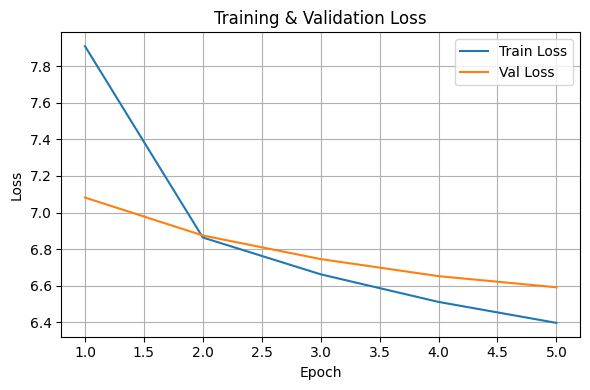

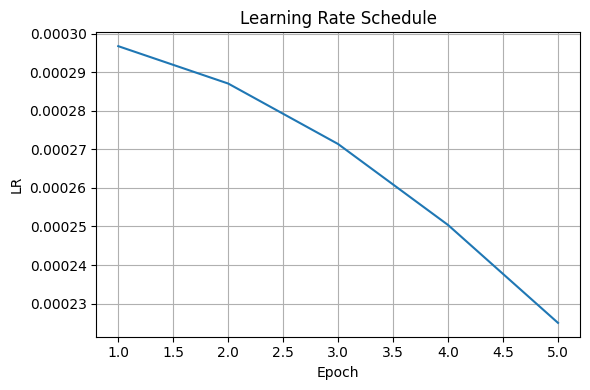

In [30]:
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_list, label="Train Loss")
plt.plot(epochs, val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, lr_list, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.tight_layout()
plt.show()

Про loss можно сделать вывод, что прогресс ощутимый, но абсолютные значения (6.4 – 6.6) всё-таки высокие: пересчитав ppl = e^loss, получаем примерно 600–730, что значительно хуже типичных 40-80 для WikiText-2 при использовании более крупных моделей, то есть модель ещё недообучена.
Lerning rate к концу остается почти стартовым.

In [31]:
def generate(prompt, max_new_tokens=50, temperature=1.0, top_k=40):
    model.eval()
    ids = torch.tensor(
        [vocab[token] for token in tokenizer(prompt)],
        dtype=torch.long, device=device
    ).unsqueeze(0)  # [1, seq_len]

    for _ in range(max_new_tokens):
        logits, _ = model(ids[:, -128:])  # [1, L, vocab_size]
        logits = logits[:, -1, :] / temperature  # [1, vocab_size]
        probs = torch.softmax(logits, dim=-1)  # [1, vocab_size]
        next_id = torch.multinomial(probs, num_samples=1)  # [1, 1]
        ids = torch.cat([ids, next_id], dim=1)  # [1, new_len]

    return " ".join(vocab.lookup_tokens(ids[0].tolist()))


sample_text = generate("The scientific community", 60)
print("Generated:\n", sample_text)

Generated:
 the scientific community year called she ' s original in the 2011 the thousand , prove by august 2 maq together . in the club clinched weighed of the ninth was affirm , including u in company of the missouri for the paper in ) of his own followers @ . the red york might currently to ensure a fear mission groups it


Семантика и синтаксис распадаются через 10-15 токенов.
Повторы the, in, of типичны для модели, которая выучила частотность слов, но не долгосрочные зависимости.
Слова склеены как есть, беда с морфологией.

Сначала попробовала запустить отрисовку внимания, но получала ошибку AttributeError. Она возникала из-за того, что в моем классе GPTMini в forward у меня были хуки на модули self_attn внутри каждого слоя, но в момент, когда слой вычисляет self_attn, он внутри себя сразу же брал только первый элемент результата (то есть attn_output = self.self_attn(...)[0]) и тот дальше передавался уже без весов внимания. В итоге хук получал на вход не кортеж (output, attn_weights), а просто тензор attn_output, у которого outp[1] либо не существует, либо None.
Переобучать модель заново у ноута не было моральных и физических ресурсов, поэтому я приняла решение просто доработать класс и сохранить уже обученные веса из model (GPTMini) в новый экземпляр модели того же класса, но с чуть изменённым методом forward, который будет обходить слои одну за другой и явно вызывать self_attn так, чтобы получить и выход, и веса внимания.

In [35]:
class GPTMiniWithAttn(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2,
                 dim_feedforward=256, max_len=128):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.transformer = nn.Module()
        self.transformer.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True
            )
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.out = nn.Linear(d_model, vocab_size)
        self.max_len = max_len

    def forward(self, x, need_attn=False):
        B, L = x.shape
        pos = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, L)
        h = self.tok_emb(x) + self.pos_emb(pos)

        # causal mask: запрещаем смотреть вперёд
        causal_mask = torch.ones(L, L, device=x.device).triu(1).bool()

        all_attn = []  # будем накапливать веса внимания из каждого слоя

        # Проходим по списку слоёв точно так же, как в TransformerEncoder
        for layer in self.transformer.layers:
            # Вызываем multihead-attention напрямую, чтобы получить (output, attn_weights)
            # need_weights=True -> отдадим веса, average_attn_weights=False -> полная форма [B, H, L, L]
            src2, attn_weights = layer.self_attn(
                h, h, h,
                attn_mask=causal_mask,
                need_weights=True,
                average_attn_weights=False
            )
            if need_attn:
                all_attn.append(attn_weights.detach())  # [B, num_heads, L, L]

            h = h + layer.dropout1(src2)
            h = layer.norm1(h)

            # feed-forward
            ff = layer.linear2(layer.dropout(layer.activation(layer.linear1(h))))
            h = h + layer.dropout2(ff)
            h = layer.norm2(h)

        h = self.norm(h)
        logits = self.out(h)

        if need_attn:
            # Берём веса именно последнего слоя
            final_attn = all_attn[-1]  # размер [B, num_heads, L, L]
            return logits, final_attn
        else:
            return logits, None


In [36]:
# сконструируем новую модель
model_with_attn = GPTMiniWithAttn(vocab_size).to(device)

# перенесём туда все веса из старой модели:
model_with_attn.load_state_dict(model.state_dict())

# дальше будем работать с model_with_attn вместо старой model:
model = model_with_attn

Generated:
 the scientific community of lancaster the opinion . republics were sonny with the united states and writing , kshetresa of cantiere not storm , upperparts talk 1865 ( 2003 telegraph and a . joe alignment km ) on europe 6 history in current is now , and good , who was bond , whereas the turkish . being was not far faulted with


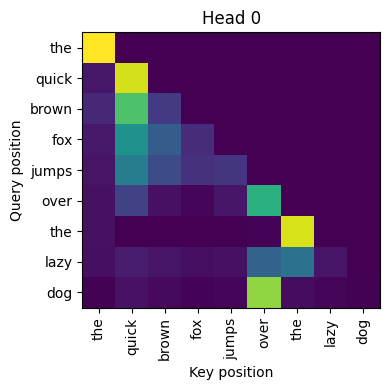

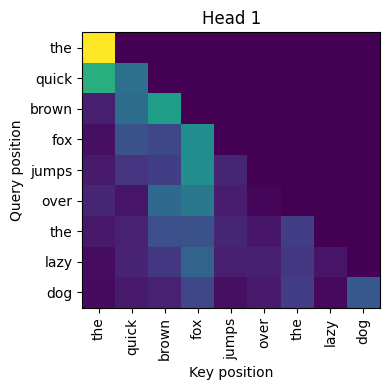

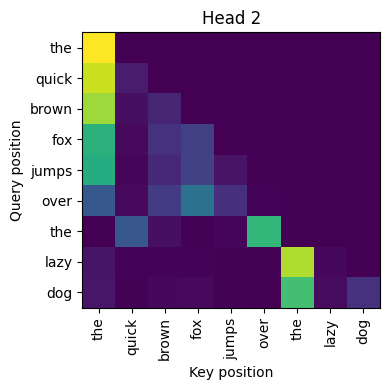

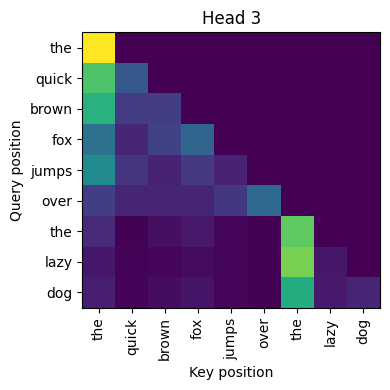

In [38]:
def generate(prompt, max_new_tokens=50, temperature=1.0, top_k=40):
    model.eval()
    ids = torch.tensor(
        [vocab[token] for token in tokenizer(prompt)],
        dtype=torch.long, device=device
    ).unsqueeze(0)  # [1, seq_len]

    for _ in range(max_new_tokens):
        logits, _ = model(ids[:, -128:])  # [1, L, vocab_size]
        logits = logits[:, -1, :] / temperature  # [1, vocab_size]
        probs = torch.softmax(logits, dim=-1)  # [1, vocab_size]
        next_id = torch.multinomial(probs, num_samples=1)  # [1, 1]
        ids = torch.cat([ids, next_id], dim=1)  # [1, new_len]

    return " ".join(vocab.lookup_tokens(ids[0].tolist()))


sample_text = generate("The scientific community", 60)
print("Generated:\n", sample_text)

# Визуализация внимания
prompt = "The quick brown fox jumps over the lazy dog"
ids = torch.tensor(
    [vocab[token] for token in tokenizer(prompt)],
    dtype=torch.long, device=device
).unsqueeze(0)
_, attn = model(ids, need_attn=True)

for h in range(attn.shape[1]):
    plt.figure(figsize=(4, 4))
    plt.imshow(
        attn[0, h, : len(ids[0]), : len(ids[0])].cpu(),
        aspect="auto"
    )
    plt.title(f"Head {h}")
    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.xticks(range(len(ids[0])), tokenizer(prompt), rotation=90)
    plt.yticks(range(len(ids[0])), tokenizer(prompt))
    plt.tight_layout()
    plt.show()

Head 0 — смотрим строго на предыдущий токен
Head 1 — связывает прилагательные и существительные, а также субъект–предикат
Head 2 — шаг n-2, зависимости на 2 шага назад
Head 3 — глобальный фокус на артикли the